# Python からC言語、Fortranを呼び出す

C言語やFortranで書かれたライブラリは、直接Pythonから呼び出すことが出来ます。

まず、C言語やFortranをコンパイルして共有ライブラリファイル(\*.so (Linux) や \*.dll)にして、
そのライブラリをPythonで読み込みます。

## Python から C言語の関数を呼び出す
まず、呼び出される側のC言語のライブラリを用意します。

ここではモンテカルロ法のための乱数の生成ライブラリ libsobol を使ってみましょう。

In [1]:
!cat libsobol.c

#include <math.h>
#include <stdint.h>
#include <stdlib.h>
int rightmost_unset_bit(int i) {
  return log2(~i & -~i) + 1; // rightmost unset bit
}
void sobol(double *points, int N) {
  int L = (unsigned)ceil(log2((double)N));
  uint64_t V[64];
  for (int j = 0; j < 2; j++) {
    for (int i = 0; i < L; i++) {
      uint64_t m = 0;
      for (int k = 0; k < 64; k += 30) {
        m = m * (RAND_MAX + 1Lu) + rand(); // 64 bit random integer
      }
      V[i] = m << (uint64_t) (63-i);
    }
    uint64_t X = 0;
    for (int i = 0; i < N; i++) {
      X = X ^ V[rightmost_unset_bit(i)];
      points[2*i+j] = X / 0x1.0p64; /* floating-point hexadecimal literal 2**64 */
    }
  }
}


In [2]:
!gcc -cpp -fPIC -shared libsobol.c -lm -o libsobol.so

ライブラリが出来ました。では早速Pythonから呼び出してみましょう。
ライブラリ **ctypes** と **numpy** を読み込みます。

In [3]:
from ctypes import *

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline 

ついでに、動いていることを確認するためにMatplotlibも読み込みました。

**`np.ctypeslib.load_library`** で読み込む共有ライブラリファイルを指定します。

In [4]:
libsobol = np.ctypeslib.load_library("libsobol.so",".")

libsobol.c で定義した関数がすべて読み込まれました。

次に、関数の引数・戻り値の型を教えてあげます。

In [5]:
# C の関数宣言式:
# void sobol(double *points, int N);

# 引数の型を指定
#         v 関数の名前
libsobol.sobol.argtypes = [np.ctypeslib.ndpointer(dtype=np.float64), c_int32]

# 戻り値の型を指定
libsobol.sobol.restype = c_void_p

代表的な型は以下のように指定します。

|   |型(C言語)        |型 (C99 stdint.h) |Python での型指定                        |
|---|----------------|------------------|---------------------------------------|
|倍精度浮動小数点数の配列|double \*       |                  |np.ctypeslib.ndpointer(dtype=np.float64)|
|単精度浮動小数点数の配列|float \*        |                  |np.ctypeslib.ndpointer(dtype=np.float32)|
|64bit整数の配列|long long int \*|int64_t \*        |np.ctypeslib.ndpointer(dtype=np.int64)  |
|32bit整数の配列|int \*          |int32_t \*         |np.ctypeslib.ndpointer(dtype=np.int32)  |
|倍精度浮動小数点数|double        |                  |c_float64|
|単精度浮動小数点数|float         |                  |c_float32|
|64bit整数|long long int |int64_t           |c_int64  |
|32bit整数|int           |int32_t           |c_int32  |
|void    |void          |                  | c_void_p |

In [6]:
# C言語の関数 sobol に渡す numpy の配列を用意します
a = np.zeros((1024, 2))

# 関数を呼び出します。
libsobol.sobol(a, 1024)

1024

C言語の関数に引数として渡された多次元配列は、C言語からは1次元配列として見えます。(`a[0, 0], a[0, 1], a[1, 0], a[1, 1] ...`)

では結果を確認してみましょう。

In [7]:
a

array([[  7.50000000e-01,   7.50000000e-01],
       [  2.50000000e-01,   0.00000000e+00],
       [  5.00000000e-01,   7.50000000e-01],
       ..., 
       [  7.50007582e-01,   7.50007582e-01],
       [  7.58240668e-06,   7.58240668e-06],
       [  4.68682963e-08,   4.68682963e-08]])

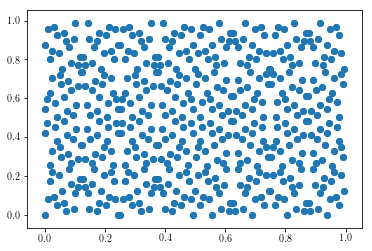

In [8]:
plt.scatter(a[:,0], a[:,1])

うまくできました。